# Task 4.1

In [ ]:
import pandas as pd
import tslearn
import numpy as np
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import tree
from sklearn import svm

In [ ]:
df = pd.read_csv("../data/CityGlobalTemperature2000-2009.csv", parse_dates=['time'])
df

,Unnamed: 0,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,time
0,1813,27.685,0.267,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-02-01
1,1814,29.061,0.224,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-03-01
2,1815,28.162,0.478,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-04-01
3,1816,27.547,0.509,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-05-01
4,1817,25.812,0.231,Abidjan,Côte D'Ivoire,5.63N,3.23W,2000-06-01
...,...,...,...,...,...,...,...,...
11995,239128,18.459,0.374,Xian,China,34.56N,108.97E,2009-09-01
11996,239129,14.195,0.163,Xian,China,34.56N,108.97E,2009-10-01
11997,239130,2.916,0.675,Xian,China,34.56N,108.97E,2009-11-01
11998,239131,-0.712,0.259,Xian,China,34.56N,108.97E,2009-12-01


Breaking original dataframe into time series, one per city.

In [ ]:
ts_for_city = {}

In [ ]:
for city in df['City'].unique():
    ts_for_city[city] = df[df['City'] == city]['AverageTemperature'].tolist()

In [ ]:
ts_dataset = to_time_series_dataset(list(ts_for_city.values()))

In [ ]:
km = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km.fit(ts_dataset)

TimeSeriesKMeans(metric='dtw')

In [ ]:
df_label = df
i = 0
for city in df['City'].unique():
    df_label.loc[df_label['City'] == city,'label'] = km.labels_[i]
    i += 1


<AxesSubplot:xlabel='time', ylabel='AverageTemperature'>

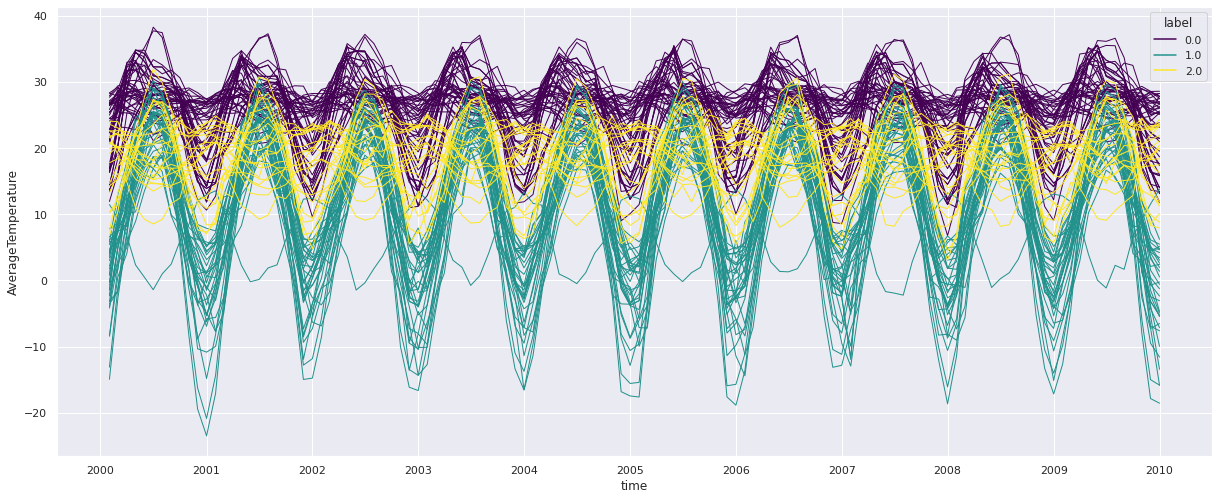

In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(20.7,8.27)})
sns.color_palette("rocket", as_cmap=True)

sns.lineplot(
    data=df_label,
    x="time", y="AverageTemperature", hue="label", units="City",
    estimator=None, lw=1, 
    palette = sns.color_palette("viridis", as_cmap=True)
)

In [ ]:
df_label[df_label['label'] == 1]['City'].unique()

array(['Ankara', 'Berlin', 'Changchun', 'Chengdu', 'Chicago', 'Dalian',
       'Harbin', 'Istanbul', 'Jinan', 'Kabul', 'Kiev', 'London', 'Madrid',
       'Mashhad', 'Montreal', 'Moscow', 'Nagoya', 'Nanjing', 'New York',
       'Paris', 'Peking', 'Rome', 'Saint Petersburg', 'Santiago', 'Seoul',
       'Shanghai', 'Shenyang', 'Taiyuan', 'Tangshan', 'Tianjin', 'Tokyo',
       'Toronto', 'Wuhan', 'Xian'], dtype=object)

In [ ]:
import re
def dm2dd(cord):

    direction = re.findall("[SNWE]", cord)[0]
    coordinates = re.findall("\d+", cord)
    degrees = coordinates[0]
    minutes = coordinates[1]

    dd = float(degrees) + float(minutes)/60;

    if direction == 'W' or direction == 'S':
        dd *= -1

    return dd;

In [ ]:
df_label_excursion = df_label
df_temp_max = df_label.groupby(['City']).max()['AverageTemperature']
df_temp_min = df_label.groupby(['City']).min()['AverageTemperature']
for city in df['City'].unique():
        df_label_excursion.loc[df_label_excursion['City'] == city,'temp_excursion'] = df_temp_max[city] - df_temp_min[city]

        latitude = df[df['City'] == city]['Latitude'].iloc[0]
        df_label_excursion.loc[df_label_excursion['City'] == city,'temp_excursion'] = dm2dd(latitude)
        
        longitude = df[df['City'] == city]['Longitude'].iloc[0]
        df_label_excursion.loc[df_label_excursion['City'] == city,'lon'] = dm2dd(longitude)
df_label_excursion = df_label_excursion.groupby(['City']).max().reset_index()
df_label_excursion

,City,Unnamed: 0,AverageTemperature,AverageTemperatureUncertainty,Country,Latitude,Longitude,time,label,temp_excursion,lat,lon
0,Abidjan,1932,29.405,1.032,Côte D'Ivoire,5.63N,3.23W,2010-01-01,0.0,6.050000,6.050000,-3.383333
1,Addis Abeba,3897,20.685,1.812,Ethiopia,8.84N,38.11E,2010-01-01,2.0,9.400000,9.400000,38.183333
2,Ahmadabad,6510,34.317,1.375,India,23.31N,72.52E,2010-01-01,0.0,23.516667,23.516667,72.866667
3,Aleppo,9179,31.957,0.804,Syria,36.17N,37.79E,2010-01-01,2.0,36.283333,36.283333,38.316667
4,Alexandria,11848,28.246,0.598,Egypt,31.35N,30.16E,2010-01-01,2.0,31.583333,31.583333,30.266667
...,...,...,...,...,...,...,...,...,...,...,...,...
95,Tokyo,229645,26.360,0.417,Japan,36.17N,139.23E,2010-01-01,1.0,36.283333,36.283333,139.383333
96,Toronto,232884,21.605,0.421,Canada,44.20N,80.50W,2010-01-01,1.0,44.333333,44.333333,-80.833333
97,Umm Durman,234741,35.658,1.804,Sudan,15.27N,32.50E,2010-01-01,0.0,15.450000,15.450000,32.833333
98,Wuhan,236814,30.729,0.544,China,29.74N,114.46E,2010-01-01,1.0,30.233333,30.233333,114.766667


In [ ]:
import plotly.express as px
token = "pk.eyJ1IjoiYmFuYW5hd2lsIiwiYSI6ImNreGdmaXgxMTBiMXIyd2tqZmxrNDQ5cDgifQ.CKq2JhGMNx_RBi9yLBg4Iw"
px.set_mapbox_access_token(token)
fig = px.scatter_mapbox(df_label_excursion, lat="lat", lon="lon", color="label", hover_name="City", size="AverageTemperature",size_max=15, zoom=1)
fig.update_layout(mapbox_style="basic", mapbox_accesstoken=token)
fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=de87b132-0371-4d99-94f9-c61923e2507d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>